In [2]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents
!pip install box2d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 784 kB in 1s (692 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselecte

In [0]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [4]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (64, 16, 4)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

In [0]:
env_name = 'BipedalWalker-v2'

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [0]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu
    )

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [0]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [0]:
def collect_episode(environment, policy, num_episodes):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1


In [0]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few episodes using collect_policy and save to the replay buffer.
    collect_episode(
            train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

    # Use data from the buffer and update the agent's network.
    experience = replay_buffer.gather_all()
    train_loss = tf_agent.train(experience)
    replay_buffer.clear()

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
step = 25: loss = -0.34972113370895386
step = 50: loss = -2.2015833854675293
step = 50: Average Return = -92.00799560546875
step = 75: loss = 5.969983100891113
step = 100: loss = 1.2938613891601562
step = 100: Average Return = -115.8797836303711
step = 125: loss = 25.03801155090332
step = 150: loss = 33.30760955810547
step = 150: Average Return = -77.11717987060547
step = 175: loss = 14.257412910461426
step = 200: loss = 18.852144241333008
step = 200: Average Return = -4.710868835449219


(-118.23558807373047, 250.0)

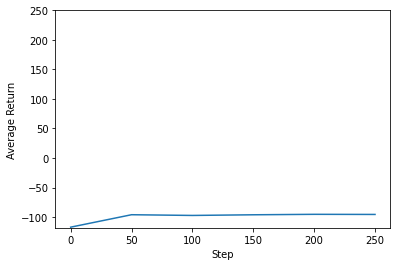

In [39]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [0]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [41]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)